## CS 5180 Reinforcement Learning and Sequential Decision Making
### Exercise 1: Multi-armed Bandits

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Q3. Implementing the 10-armed testbed

In [3]:
class TestBed:
    def __init__(self):
        self.levers = 10
        self.true_means = []
        self.optimal_action = None

    def set_true_means(self):
        self.true_means = np.random.normal(0, scale= 1, size=(1, self.levers))[0].tolist()
        self.optimal_action = self.true_means.index(max(self.true_means))

    def pull_lever(self, k:int):
        return np.random.normal(self.true_means[k], scale=1)
    
testbed = TestBed()

### Q3. Plotting the testbed

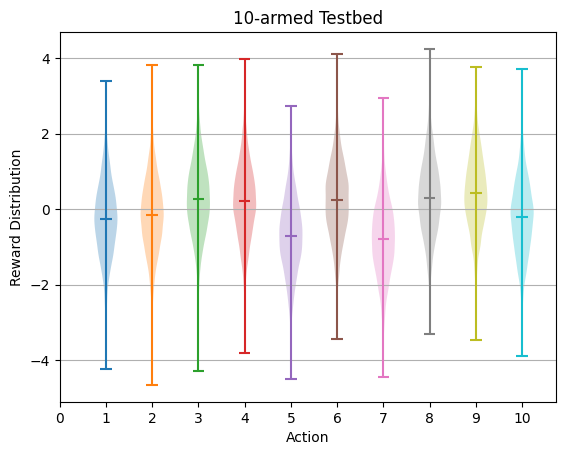

In [27]:
num_pulls_each_lever = 10000
sample_data = np.ndarray([testbed.levers, num_pulls_each_lever])

for pull in range(num_pulls_each_lever):
    for lever in range(testbed.levers):
        sample_data[lever][pull] = testbed.pull_lever(lever)

for lever in range(testbed.levers):
    plt.violinplot(sample_data[lever][:], [lever+1], showmeans=True)

plt.title("10-armed Testbed")
plt.xlabel("Action")
plt.ylabel("Reward Distribution")
plt.grid(True, axis="y")
plt.xticks([i for i in range(testbed.levers+1)])
plt.show()


### Class which implements the E-Greedy Policy

In [13]:
class EGreedy:
    def __init__(self):
        self.e = 0
        self.estimated_Q = [0 for i in range(testbed.levers)]
        self.pull_count_n = [0 for i in range(testbed.levers)]
        self.alpha = None
        

    def reset(self, epsilon = 0, Q = 0):
        self.estimated_Q = [Q for i in range(testbed.levers)]
        self.pull_count_n = [0 for i in range(testbed.levers)]
        self.num_optimal_action = 0
        self.e = epsilon

    def update_estimate(self, lever, reward):        
        
        if self.alpha is None:
            self.estimated_Q[lever] = self.estimated_Q[lever] + (1/self.pull_count_n[lever])*(reward - self.estimated_Q[lever])
        
        else:
            self.estimated_Q[lever] = self.estimated_Q[lever] + self.alpha*(reward - self.estimated_Q[lever])
        
    def get_action(self):
        greedy_action = np.random.choice([True, False], 1, p=[1-self.e, self.e])[0]
        
        if greedy_action:
            lever_to_pull = self.estimated_Q.index(max(self.estimated_Q))
            
            reward = testbed.pull_lever(lever_to_pull)
            self.pull_count_n[lever_to_pull] += 1

        else:
            lever_to_pull = np.random.randint(testbed.levers)
            reward = testbed.pull_lever(lever_to_pull)
            self.pull_count_n[lever_to_pull] += 1
        
        is_optimal_action = 1 if lever_to_pull == testbed.optimal_action else 0

        self.update_estimate(lever_to_pull, reward)
        return reward, is_optimal_action
    
e_greedy = EGreedy()

### Implementation of the E-Greedy Policy for Different Values of E

In [14]:
num_steps = 10000
num_trials = 2000
epsilon = [0, 0.1, 0.01]

In [18]:
# reward_array = np.ndarray([len(epsilon), num_trials, num_steps])
# percent_optimal_action_array = np.zeros([len(epsilon), num_steps])
# max_true_mean_rewards = np.zeros(num_trials)

# for trial in range(num_trials):
#     testbed.set_true_means()
#     max_true_mean_rewards[trial] = max(testbed.true_means)
#     print("Trial: ", trial+1, end='\r')
#     for e_index, e in enumerate(epsilon):
#         e_greedy.reset(e)
        
#         for step in range(num_steps):
#             reward, is_optimal_action = e_greedy.get_action()
#             reward_array[e_index][trial][step] = reward
            
#             percent_optimal_action_array[e_index][step] += is_optimal_action

# np.save("reward_array", reward_array)
# np.save("max_true_mean_rewards", max_true_mean_rewards)
# np.save("percent_optimal_action_array", percent_optimal_action_array)

In [23]:
reward_array = np.load("reward_array.npy")
max_true_mean_rewards = np.load("max_true_mean_rewards.npy")
percent_optimal_action_array = np.load("percent_optimal_action_array.npy")

### Q5. Reproducing Figure 2.2

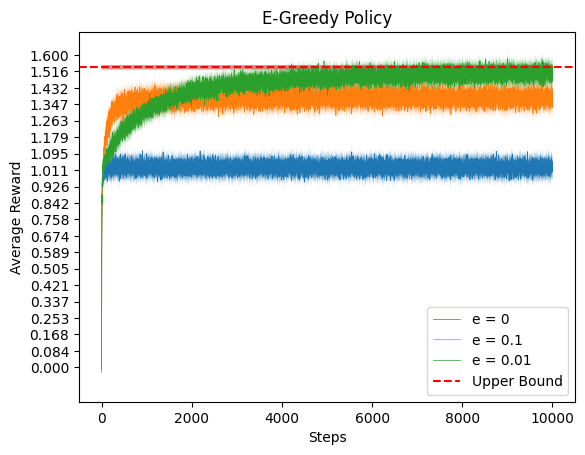

In [33]:
avg_rewards = np.mean(reward_array, axis=1)
sd_avg_rewards = np.std(reward_array, axis=1)
sd_max_true_mean_rewards = np.std(max_true_mean_rewards)
avg_max_true_mean_rewards = np.mean(max_true_mean_rewards)

std_error_avg_rewards = sd_avg_rewards/np.sqrt(num_trials)
std_error_best_avg_reward = sd_max_true_mean_rewards/np.sqrt(num_steps)

for e_index, e in enumerate(epsilon):
    plt.plot(avg_rewards[e_index], label=f"e = {e}", linewidth = 0.5)
    plt.fill_between(np.linspace(1, num_steps, num=num_steps), 
                     avg_rewards[e_index] + 1.96*std_error_avg_rewards[e_index],
                     avg_rewards[e_index] - 1.96*std_error_avg_rewards[e_index], alpha=1)

plt.axhline(y = avg_max_true_mean_rewards, linestyle = "--", color = "r", label = "Upper Bound")
plt.fill_between(np.linspace(0, num_steps, num=num_steps), 
                 avg_max_true_mean_rewards + 1.96*std_error_best_avg_reward,
                 avg_max_true_mean_rewards - 1.96*std_error_best_avg_reward, 
                 alpha = 0.51)

plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.yticks(np.linspace(0, 1.6, num=20))
plt.legend()
plt.title("E-Greedy Policy")
plt.show()

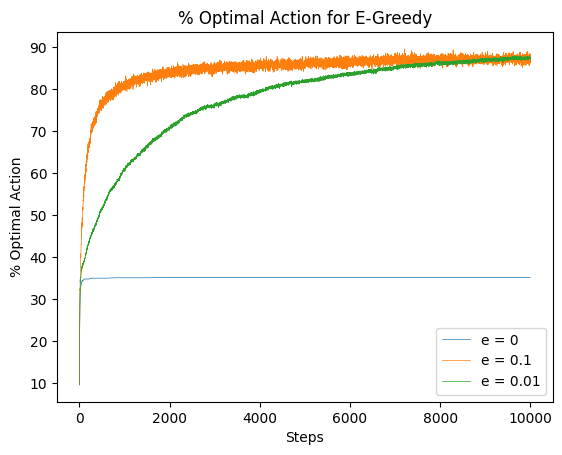

In [8]:
avg_optimal_action = (percent_optimal_action_array/num_trials)*100
for e_index, e in enumerate(epsilon):
    plt.plot(avg_optimal_action[e_index], label=f"e = {e}", linewidth=0.5)

plt.xlabel("Steps")
plt.ylabel("% Optimal Action")
plt.legend()
plt.title("% Optimal Action for E-Greedy")
plt.show()

### Q7. Implemetation of E-Greedy Policy with Optimistic Values

In [32]:
num_steps = 10000
num_trials = 2000
Q_E_pair = [(5, 0), (0, 0.1), (5, 0.1), (0, 0)]

In [22]:
# The suffix op_g translates to optimistic greedy
reward_array_op_g = np.ndarray([len(Q_E_pair), num_trials, num_steps])
percent_optimal_action_array_op_g = np.zeros([len(Q_E_pair), num_steps])
max_true_mean_rewards_op_g = np.zeros(num_trials)

e_greedy.alpha = 0.1

for trial in range(num_trials):
    testbed.set_true_means()
    max_true_mean_rewards_op_g[trial] = max(testbed.true_means)
    print("Trial: ", trial+1, end='\r')
    
    for q_e_index, q_e in enumerate(Q_E_pair):
        e_greedy.reset(epsilon=q_e[1], Q=q_e[0])

        for step in range(num_steps):
            reward, is_optimal_action = e_greedy.get_action()
            reward_array_op_g[q_e_index][trial][step] = reward
            
            percent_optimal_action_array_op_g[q_e_index][step] += is_optimal_action

# np.save("reward_array_op_g", reward_array_op_g)
# np.save("max_true_mean_rewards_op_g", max_true_mean_rewards_op_g)
# np.save("percent_optimal_action_array_op_g", percent_optimal_action_array_op_g)

In [34]:
reward_array_op_g = np.load("reward_array_op_g.npy")
max_true_mean_rewards_op_g = np.load("max_true_mean_rewards_op_g.npy")
percent_optimal_action_array_op_g = np.load("percent_optimal_action_array_op_g.npy")

### Q7. Reproducing Figures 2.3 and 2.4

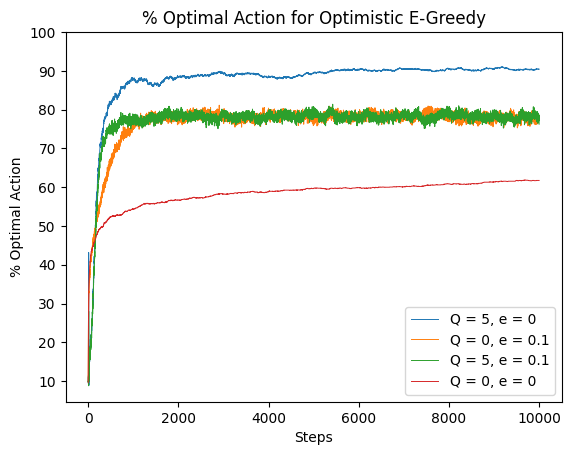

In [38]:
avg_optimal_action = (percent_optimal_action_array_op_g/num_trials)*100

for q_e_index, q_e in enumerate(Q_E_pair):
    plt.plot(avg_optimal_action[q_e_index], label=f"Q = {q_e[0]}, e = {q_e[1]}", linewidth = 0.7)

plt.xlabel("Steps")
plt.ylabel("% Optimal Action")
plt.yticks([y*10 for y in range(1, 11)])
plt.legend()
plt.title("% Optimal Action for Optimistic E-Greedy")
plt.show()

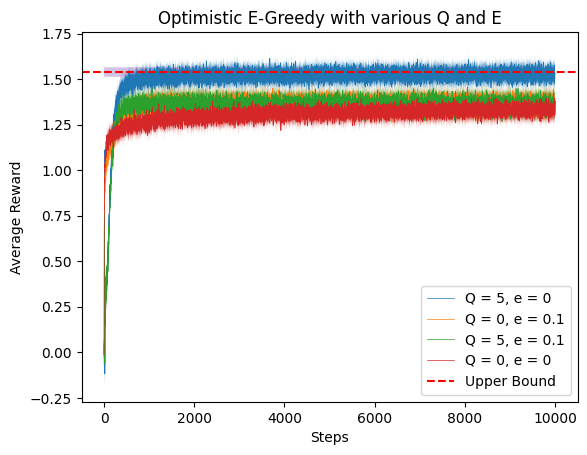

In [39]:
avg_rewards_op_g = np.mean(reward_array_op_g, axis=1)
sd_avg_rewards_op_g = np.std(reward_array_op_g, axis=1)
sd_max_true_mean_rewards_op_g = np.std(max_true_mean_rewards_op_g)
avg_max_true_mean_rewards_op_g = np.mean(max_true_mean_rewards_op_g)

std_error_avg_rewards_op_g = sd_avg_rewards_op_g/np.sqrt(num_trials)
std_error_best_avg_reward_op_g = sd_max_true_mean_rewards_op_g/np.sqrt(num_trials)

for q_e_index, q_e in enumerate(Q_E_pair):
    plt.fill_between(np.linspace(1, num_steps, num=num_steps), 
                     avg_rewards_op_g[q_e_index] + 1.96*std_error_avg_rewards_op_g[q_e_index],
                     avg_rewards_op_g[q_e_index] - 1.96*std_error_avg_rewards_op_g[q_e_index])
    plt.plot(avg_rewards_op_g[q_e_index], label=f"Q = {q_e[0]}, e = {q_e[1]}", linewidth = 0.5)

plt.axhline(y = avg_max_true_mean_rewards_op_g, linestyle = "--", color = "r", label = "Upper Bound")
plt.fill_between(np.linspace(0, num_steps, num=num_steps), 
                 avg_max_true_mean_rewards_op_g + 1.96*std_error_best_avg_reward_op_g,
                 avg_max_true_mean_rewards_op_g - 1.96*std_error_best_avg_reward_op_g, 
                 alpha = 0.4)

plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.title("Optimistic E-Greedy with various Q and E")
plt.show()

### Q7. Implementation of UCB


In [14]:
class UCB:
    def __init__(self):
        self.pull_count_n = np.zeros(testbed.levers)
        self.estimated_Q = np.zeros(testbed.levers)
        self.uncertainty_term = np.array([np.inf for _ in range(testbed.levers)])
        self.c = 2
        self.t = 0

    def reset(self):
        self.__init__()

    def __update_estimate(self, lever, reward):        
        self.estimated_Q[lever] = self.estimated_Q[lever] + (1/self.pull_count_n[lever])*(reward - self.estimated_Q[lever])
    
    def __update_uncertainty(self, lever):
        for l in range(testbed.levers):
            if self.pull_count_n[l] == 0:
                continue
            self.uncertainty_term[l] = self.c*np.sqrt(np.log(self.t)/self.pull_count_n[l])

    def get_action(self):
        lever_to_pull = np.argmax(self.estimated_Q + self.uncertainty_term)
        
        is_optimal_action = 1 if lever_to_pull == testbed.optimal_action else 0

        reward = testbed.pull_lever(lever_to_pull)
        self.t += 1
        self.pull_count_n[lever_to_pull] += 1

        self.__update_estimate(lever_to_pull, reward)
        self.__update_uncertainty(lever_to_pull)

        return reward, is_optimal_action
        # print(lever_to_pull)
        # print(self.estimated_Q + self.uncertainty_term)

ucb = UCB()

In [19]:
num_steps = 10000
num_trials = 2000

reward_array_ucb = np.ndarray([num_trials, num_steps])
percent_optimal_action_array_ucb = np.zeros(num_steps)
max_true_mean_rewards_ucb = np.zeros(num_trials)

for trial in range(num_trials):
    testbed.set_true_means()
    max_true_mean_rewards_ucb[trial] = max(testbed.true_means)
    print("Trial: ", trial+1, end='\r')
    ucb.reset()

    for step in range(num_steps):
        reward, is_optimal_action = ucb.get_action()
        reward_array_ucb[trial][step] = reward
        
        percent_optimal_action_array_ucb[step] += is_optimal_action

# np.save("reward_array_ucb", reward_array_ucb)
# np.save("max_true_mean_rewards_ucb", max_true_mean_rewards_ucb)
# np.save("percent_optimal_action_array_ucb", percent_optimal_action_array_ucb)

In [30]:
reward_array_ucb = np.load("reward_array_ucb.npy")
max_true_mean_rewards_ucb = np.load("max_true_mean_rewards_ucb.npy")
percent_optimal_action_array_ucb = np.load("percent_optimal_action_array_ucb.npy")

### Q7. Plotting of the UCB

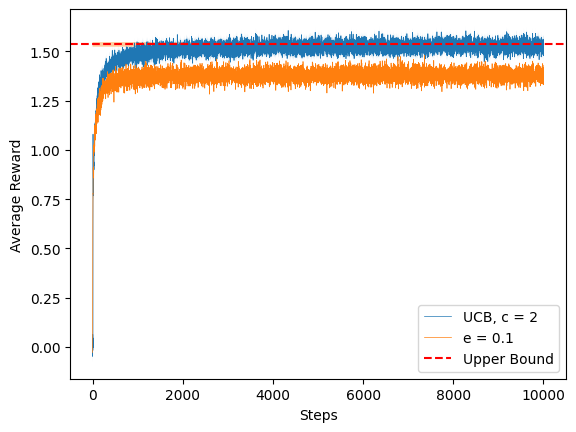

In [34]:
avg_rewards_ucb = np.mean(reward_array_ucb, axis=0)
sd_avg_rewards_ucb = np.std(reward_array_ucb, axis=0)
sd_max_true_mean_rewards_ucb = np.std(max_true_mean_rewards_ucb)
avg_max_true_mean_rewards_ucb = np.mean(max_true_mean_rewards_ucb)

std_error_avg_rewards_ucb = sd_avg_rewards_ucb/np.sqrt(num_steps)
std_error_best_avg_reward_ucb = sd_max_true_mean_rewards_ucb/np.sqrt(num_steps)


plt.fill_between(np.linspace(0, num_steps, num=num_steps), 
                    avg_rewards_ucb + 1.96*std_error_avg_rewards_ucb,
                    avg_rewards_ucb - 1.96*std_error_avg_rewards_ucb)
plt.plot(avg_rewards_ucb, label=f"UCB, c = 2", linewidth = 0.5)

plt.plot(avg_rewards[1], label = "e = 0.1", linewidth=0.5 )
plt.axhline(y = avg_max_true_mean_rewards_ucb, linestyle = "--", color = "r", label = "Upper Bound")
plt.fill_between(np.linspace(0, num_steps, num=num_steps), 
                 avg_max_true_mean_rewards_ucb + 1.96*std_error_best_avg_reward_ucb,
                 avg_max_true_mean_rewards_ucb - 1.96*std_error_best_avg_reward_ucb, 
                 alpha = 0.4)

plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

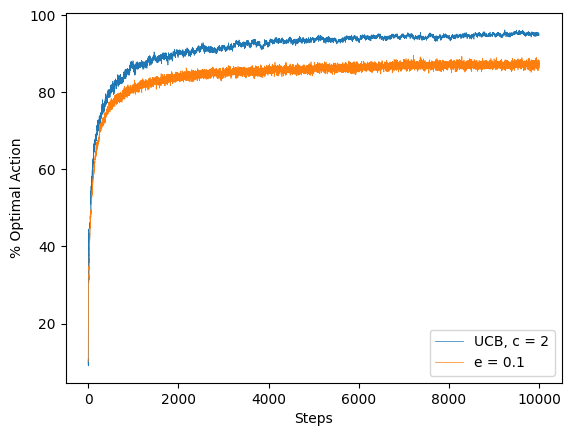

In [ ]:
avg_optimal_action_ucb = (percent_optimal_action_array_ucb/num_trials)*100
avg_optimal_action_e = (percent_optimal_action_array[1][:]/num_trials)*100

plt.plot(avg_optimal_action_ucb, label=f"UCB, c = 2", linewidth = 0.5)
plt.plot(avg_optimal_action_e, label = "e = 0.1", linewidth = 0.5)

plt.xlabel("Steps")
plt.ylabel("% Optimal Action")
plt.legend()
plt.show()